<a href="https://colab.research.google.com/github/duybluemind1988/Data-science/blob/master/Time_series/Time_series_all_method_2(multy).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Predicting returns with a cross-asset mementum model

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import mean_squared_error
#import yfinance as yf
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode

In [ ]:
!pip install yahoo_fin

In [ ]:
from yahoo_fin.stock_info import get_data

stock_code={'Apple':'AAPL', 'Microsoft':'MSFT','Facebook':'Fb','Amazon':'AMZN',
            'Twitter':'TWTR','SP500':'^GSPC'}

df= get_data(stock_code['SP500'],  start_date = '2016-01-01',
                          end_date='2020-09-05',
                      index_as_date = True, interval="1d")
df_sp500=df['adjclose']
df_sp500

2016-01-04    2012.660034
2016-01-05    2016.709961
2016-01-06    1990.260010
2016-01-07    1943.089966
2016-01-08    1922.030029
                 ...     
2020-08-31    3500.310059
2020-09-01    3526.649902
2020-09-02    3580.840088
2020-09-03    3455.060059
2020-09-04    3426.959961
Name: adjclose, Length: 1178, dtype: float64

In [ ]:
df_gld= get_data("GLD",start_date = '2016-01-01',end_date='2020-09-05',
                      index_as_date = True, interval="1d") # Gold price
df_dxy= get_data("UUP",start_date = '2016-01-01',end_date='2020-09-05',
                      index_as_date = True, interval="1d") # Invesco DB US Dollar 
df_ief= get_data("IEF",start_date = '2016-01-01',end_date='2020-09-05',
                      index_as_date = True, interval="1d") # 10 Year Treasury Bond 
df_gush= get_data("GUSH",start_date = '2016-01-01',end_date='2020-09-05',
                      index_as_date = True, interval="1d") # Direxion Daily S&P Oil & Gas Exp. & Prod. Bull 2X Shares

In [ ]:
df_assets = pd.DataFrame({
    'GUSH':df_gush['adjclose'],
    'GLD': df_gld['adjclose'],
    'UUP': df_dxy['adjclose'],
    'IEF': df_ief['adjclose'],
})
df_assets

,GUSH,GLD,UUP,IEF
2016-01-04,13072.905273,102.889999,24.894354,97.151749
2016-01-05,12937.333984,103.180000,25.039707,97.124275
2016-01-06,10225.916992,104.669998,24.971874,97.710609
2016-01-07,9538.379883,106.150002,24.719925,97.921371
2016-01-08,9571.303711,105.680000,24.768377,98.168747
...,...,...,...,...
2020-08-31,32.180000,184.830002,24.900000,121.422005
2020-09-01,31.930000,185.050003,24.950001,121.820000
2020-09-02,30.260000,182.619995,25.040001,121.989998
2020-09-03,29.690001,181.139999,25.049999,122.150002


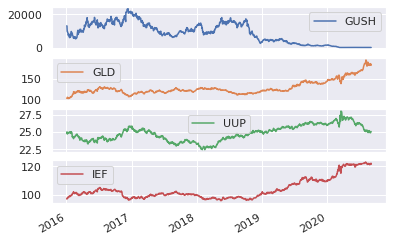

In [ ]:
df_assets.plot(subplots=True)
plt.show()

In [ ]:
# Not used
df_assets_1m = df_assets.pct_change(periods=20)
df_assets_1m.columns = ['%s_1m'%col for col in df_assets.columns]
df_assets_3m = df_assets.pct_change(periods=60)
df_assets_3m.columns = ['%s_3m'%col for col in df_assets.columns]
df_assets_6m = df_assets.pct_change(periods=120)
df_assets_6m.columns = ['%s_6m'%col for col in df_assets.columns]
df_lagged = df_assets_1m.join(df_assets_3m)\
    .join(df_assets_6m)\
    .dropna()
df_lagged

,GUSH_1m,GLD_1m,UUP_1m,IEF_1m,GUSH_3m,GLD_3m,UUP_3m,IEF_3m,GUSH_6m,GLD_6m,UUP_6m,IEF_6m
2016-06-24,-0.089693,0.080803,0.005274,0.023376,0.362538,0.071064,0.009780,0.021509,0.069037,0.224609,-0.035422,0.065996
2016-06-27,-0.221128,0.095658,0.008068,0.034201,0.208813,0.083383,0.018752,0.030639,-0.088323,0.227757,-0.032895,0.075516
2016-06-28,-0.131674,0.079786,0.001208,0.032793,0.429689,0.078950,0.014688,0.029242,0.315152,0.197287,-0.034924,0.068873
2016-06-29,-0.102122,0.085389,0.003644,0.028942,0.561814,0.069522,0.010599,0.020984,0.503147,0.185492,-0.028224,0.062237
2016-06-30,-0.134927,0.093369,0.004448,0.028033,0.381693,0.081495,0.014706,0.025472,0.456900,0.196726,-0.028169,0.061910
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,-0.027501,-0.004363,-0.015032,-0.009214,-0.395541,0.169736,-0.049981,0.016272,0.109911,0.200741,-0.048165,0.034337
2020-09-01,-0.070992,-0.023946,-0.009528,-0.009359,-0.523891,0.158590,-0.045524,0.018498,0.478582,0.252115,-0.056354,0.037200
2020-09-02,-0.157338,-0.045623,-0.001595,-0.004660,-0.470394,0.132457,-0.039140,0.016274,-0.022384,0.274567,-0.087464,0.045463
2020-09-03,-0.143393,-0.065759,-0.001196,-0.004491,-0.390834,0.107416,-0.033938,0.010052,0.217084,0.278876,-0.056852,0.019892


# Model

## Linger Regression (dynamic model)

Tóm tắt:
Viết chương trình để xác định giá trị cổ phiếu SP500 dựa trên giá trị cổ phiếu gold, oil.... (pair trading). Lấy 20 giá trị trước hiện tại của GS train với 20 giá trị trước hiện tại của jpm, sau đó lấy model này predict giá trị hiện tại jpm dựa trên giá trị hiện tại của GS. model liner sẽ train và predict từng cặp 20 giá trị này cho tới hết data set.

Training set:

x.shape (20, 1)

y.ravel().shape (20,)

X: 20 sample, 1 feature; Y: 20 samples

Khi lấy model này predict bao nhiêu giá trị x thì sẽ có tương ứng bấy nhiêu giá trị y. Ở đây train x và y theo 1-1, tức là chúng ta có linear model của 20 giá trị x theo 20 giá trị y, dùng model này để predict giá trị current

Đây là model sống, nghĩa là model parameter sẽ thay đổi theo mỗi 20 giá trị tiếp theo, sau đó predict giá trị current. Cách train này khá hay , giống với ARIMA

ML thông thường: X (2658,60); Y (2658,) tức là X có 60 features tượng trưng 60 timesteps, 2658 phần tử. Y cũng có 2658 giá trị tương ứng với 2658 giá trị X. Sau khi train hết rồi thì được model, model này sẽ dùng để predict X test (300,60). Đây là model chết do chỉ dùng parameter cũ để predict y theo X, mặc dù X ở đây là giá trị gần với y (30 or 60 ngày gần nhất)

In [ ]:
from sklearn.linear_model import LinearRegression

class LinearRegressionModel(object):
    def __init__(self):
        self.df_result = pd.DataFrame(columns=['Actual', 'Predicted'])

    def get_model(self):
        return LinearRegression(fit_intercept=False)

    def learn(self, df, ys, start_date, end_date, lookback_period=20):
        model = self.get_model()
        #print('++def learn')
        #print('start_date',start_date)
        #print('end_date',start_date)
        #print('lookback_period',lookback_period)
        for date in df[start_date:end_date].index:
            # Fit the model
            x = self.get_prices_since(df, date, lookback_period)
            y = self.get_prices_since(ys, date, lookback_period)
            #print('----date',date)
            #print('x',x)
            #print('y',y)
            #print('y.ravel()',y.ravel())
            #print('x.shape',x.shape)
            #print('y.ravel().shape',y.ravel().shape)
            model.fit(x, y.ravel())
            #print('model.predict(x)',model.predict(x))
            # Predict the current period
            #print('Predict the current period')
            #print('date ',date)
            x_current = df.loc[date].values
            [y_pred] = model.predict([x_current])
            #print('x_current',x_current)
            #print('[y_pred]',[y_pred])

            # Store predictions
            new_index = pd.to_datetime(date, format='%Y-%m-%d')
            y_actual = ys.loc[date]
            #print('y_actual',y_actual)
            self.df_result.loc[new_index] = [y_actual, y_pred]

    def get_prices_since(self, df, date_since, lookback):

        index = df.index.get_loc(date_since) # current date
        #print('++def get_prices_since')
        #print('date_since',date_since)
        #print('index',index)
        #print('index-lookback:index',index-lookback,index) 
        return df.iloc[index-lookback:index] #current date - 20 : current date


In [ ]:
df_sp500

2016-01-04    2012.660034
2016-01-05    2016.709961
2016-01-06    1990.260010
2016-01-07    1943.089966
2016-01-08    1922.030029
                 ...     
2020-08-31    3500.310059
2020-09-01    3526.649902
2020-09-02    3580.840088
2020-09-03    3455.060059
2020-09-04    3426.959961
Name: adjclose, Length: 1178, dtype: float64

In [ ]:
df_assets

,GUSH,GLD,UUP,IEF
2016-01-04,13072.905273,102.889999,24.894354,97.151749
2016-01-05,12937.333984,103.180000,25.039707,97.124275
2016-01-06,10225.916992,104.669998,24.971874,97.710609
2016-01-07,9538.379883,106.150002,24.719925,97.921371
2016-01-08,9571.303711,105.680000,24.768377,98.168747
...,...,...,...,...
2020-08-31,32.180000,184.830002,24.900000,121.422005
2020-09-01,31.930000,185.050003,24.950001,121.820000
2020-09-02,30.260000,182.619995,25.040001,121.989998
2020-09-03,29.690001,181.139999,25.049999,122.150002


In [ ]:
linear_reg_model = LinearRegressionModel()
linear_reg_model.learn(df_assets, df_sp500, start_date='2017', 
                       end_date='2020', lookback_period=10)

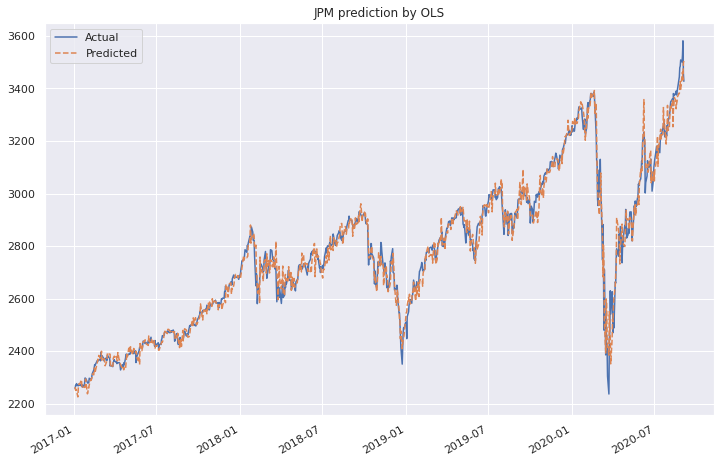

In [ ]:
linear_reg_model.df_result.plot(
    title='JPM prediction by OLS', 
    style=['-', '--'], figsize=(12,8));

In [ ]:
linear_reg_model.df_result

,Actual,Predicted
2017-01-03,2257.830078,2264.084740
2017-01-04,2270.750000,2251.630106
2017-01-05,2269.000000,2254.861399
2017-01-06,2276.979980,2250.920645
2017-01-09,2268.899902,2226.464370
...,...,...
2020-08-31,3500.310059,3450.913382
2020-09-01,3526.649902,3461.757692
2020-09-02,3580.840088,3431.633567
2020-09-03,3455.060059,3497.122739


In [ ]:
y_test=linear_reg_model.df_result.Actual[-186:]
y_test_pred=linear_reg_model.df_result.Predicted[-186:]

In [ ]:
print('test rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)))

test rmse: 63.54540410583514


In [ ]:
def profit(true,predict):
  buy=0
  win=0
  lose=0
  revenue=[]
  for i in range(len(predict)-1):
    if predict.values[i+1] > true.values[i]:
      buy+=1
      result=true.values[i+1]-true.values[i]
      revenue.append(result)
      if result >0:
        win+=1
      else:
        lose+=1
  print('total buy',buy)      
  print('ratio buy/all test set:',buy/len(predict))      
  print('win num',win)
  print('lose num',lose)
  print('revenue',sum(revenue))

In [ ]:
profit(y_test,y_test_pred)

total buy 98
ratio buy/all test set: 0.5268817204301075
win num 72
lose num 26
revenue 2027.949462890625


## Other ML Methods (dynamic model)

In [ ]:
from sklearn.pipeline import Pipeline
#ML normal ML
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import TheilSenRegressor, HuberRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
#ML ensembles
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
#Special
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [ ]:
from sklearn.linear_model import LinearRegression

class LinearRegressionModel(object):
    def __init__(self):
        self.df_result = pd.DataFrame(columns=['Actual', 'Predicted'])

    def get_model(self):
        return LinearRegression(fit_intercept=False)

    def learn(self, df, ys, start_date, end_date, lookback_period=20):
        model = self.get_model()

        for date in df[start_date:end_date].index:
            # Fit the model
            x = self.get_prices_since(df, date, lookback_period)
            y = self.get_prices_since(ys, date, lookback_period)
            model.fit(x, y.ravel())
            # Predict the current period
            x_current = df.loc[date].values
            [y_pred] = model.predict([x_current])
            # Store predictions
            new_index = pd.to_datetime(date, format='%Y-%m-%d')
            y_actual = ys.loc[date]
            self.df_result.loc[new_index] = [y_actual, y_pred]

    def get_prices_since(self, df, date_since, lookback):

        index = df.index.get_loc(date_since) # current date
        return df.iloc[index-lookback:index] #current date - 20 : current date


In [ ]:
from sklearn.linear_model import Ridge
# class Ridge kế thừa tất cả thuộc tính của class Linear, chỉ thay đổi get_model method
class RidgeRegressionModel(LinearRegressionModel):        
    def get_model(self):
        return Ridge(alpha=.5)
ridge_reg_model = RidgeRegressionModel()
ridge_reg_model.learn(df_assets, df_sp500, start_date='2017', 
                       end_date='2020', lookback_period=10)

test rmse: 63.54540410583514
total buy 98
ratio buy/all test set: 0.5268817204301075
win num 72
lose num 26
revenue 2027.949462890625


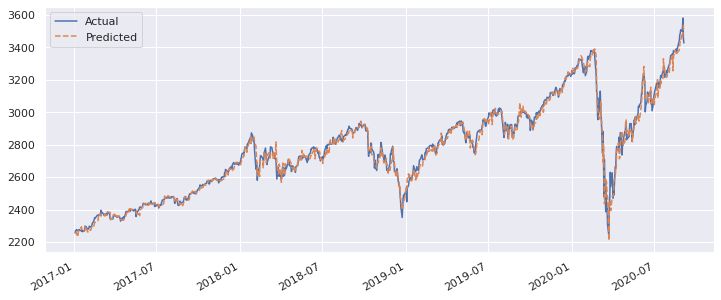

In [ ]:
ridge_reg_model.df_result.plot(
    #title='JPM prediction by OLS', 
    style=['-', '--'], figsize=(12,5));

y_test=linear_reg_model.df_result.Actual[-186:]
y_test_pred=linear_reg_model.df_result.Predicted[-186:]
print('test rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)))
profit(y_test,y_test_pred)

In [ ]:
class DecisionTreeRegressor_model(LinearRegressionModel):        
    def get_model(self):
        return DecisionTreeRegressor()
model = DecisionTreeRegressor_model()
model.learn(df_assets, df_sp500, start_date='2017', 
                       end_date='2020', lookback_period=10)

test rmse: 75.67640664944723
total buy 30
ratio buy/all test set: 0.16129032258064516
win num 24
lose num 6
revenue 813.0703125


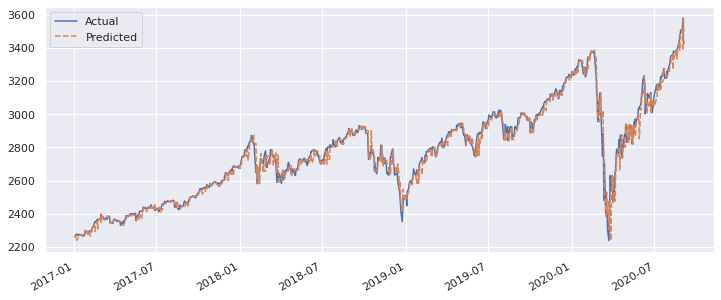

In [ ]:
model.df_result.plot(
    #title='JPM prediction by OLS', 
    style=['-', '--'], figsize=(12,5));

y_test=model.df_result.Actual[-186:]
y_test_pred=model.df_result.Predicted[-186:]
print('test rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)))
profit(y_test,y_test_pred)

test rmse: 68.06999290023091
total buy 62
ratio buy/all test set: 0.3333333333333333
win num 42
lose num 20
revenue 704.919921875


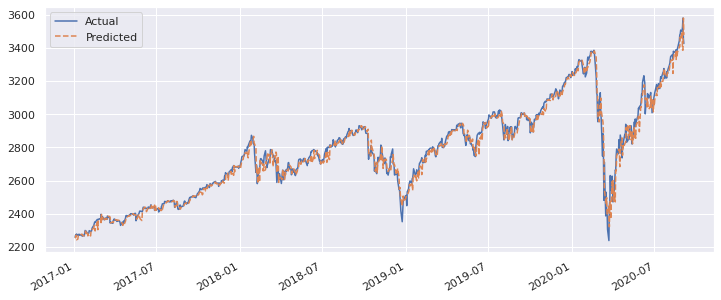

In [ ]:
class GradientBoostingRegressor_model(LinearRegressionModel):        
    def get_model(self):
        return GradientBoostingRegressor()
model = GradientBoostingRegressor_model()
model.learn(df_assets, df_sp500, start_date='2017', 
                       end_date='2020', lookback_period=10)

model.df_result.plot(
    #title='JPM prediction by OLS', 
    style=['-', '--'], figsize=(12,5));

y_test=model.df_result.Actual[-186:]
y_test_pred=model.df_result.Predicted[-186:]
print('test rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)))
profit(y_test,y_test_pred)

## LSTM predict multy feature (not dynamic model)

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import mean_squared_error
# univariate mlp example
import warnings
from numpy import array
import matplotlib.pyplot as plt
from keras import optimizers
from keras import backend
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM,GRU, RepeatVector, TimeDistributed, Flatten,Bidirectional
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l1
from keras.regularizers import l2
from keras.regularizers import l1_l2
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Dense
from keras.metrics import categorical_crossentropy

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [ ]:
from yahoo_fin.stock_info import get_data

stock_code={'Apple':'AAPL', 'Microsoft':'MSFT','Facebook':'Fb','Amazon':'AMZN',
            'Twitter':'TWTR','SP500':'^GSPC'}

df= get_data(stock_code['SP500'],  start_date = '2017-01-01',
                          end_date='2020-09-05',
                      index_as_date = True, interval="1d")
df_sp500=df['adjclose']

df_gld= get_data("GLD",start_date = '2017-01-01',end_date='2020-09-05',
                      index_as_date = True, interval="1d") # Gold price
df_dxy= get_data("UUP",start_date = '2017-01-01',end_date='2020-09-05',
                      index_as_date = True, interval="1d") # Invesco DB US Dollar 
df_ief= get_data("IEF",start_date = '2017-01-01',end_date='2020-09-05',
                      index_as_date = True, interval="1d") # 10 Year Treasury Bond 
df_gush= get_data("GUSH",start_date = '2017-01-01',end_date='2020-09-05',
                      index_as_date = True, interval="1d") # Direxion Daily S&P Oil & Gas Exp. & Prod. Bull 2X Shares
df_assets = pd.DataFrame({
    'GUSH':df_gush['adjclose'],
    'GLD': df_gld['adjclose'],
    'UUP': df_dxy['adjclose'],
    'IEF': df_ief['adjclose'],
})
df_assets

,GUSH,GLD,UUP,IEF
2017-01-03,21088.333984,110.470001,25.873072,97.661842
2017-01-04,21383.804688,110.860001,25.679264,97.773666
2017-01-05,21168.191406,112.580002,25.407936,98.407555
2017-01-06,20679.062500,111.750000,25.592051,97.960114
2017-01-09,19006.050781,112.669998,25.524220,98.332977
...,...,...,...,...
2020-08-31,32.180000,184.830002,24.900000,121.422005
2020-09-01,31.930000,185.050003,24.950001,121.820000
2020-09-02,30.260000,182.619995,25.040001,121.989998
2020-09-03,29.690001,181.139999,25.049999,122.150002


In [ ]:
df=df_assets.merge(df_sp500,left_index=True,right_index=True)
df

,GUSH,GLD,UUP,IEF,adjclose
2017-01-03,21088.333984,110.470001,25.873072,97.661842,2257.830078
2017-01-04,21383.804688,110.860001,25.679264,97.773666,2270.750000
2017-01-05,21168.191406,112.580002,25.407936,98.407555,2269.000000
2017-01-06,20679.062500,111.750000,25.592051,97.960114,2276.979980
2017-01-09,19006.050781,112.669998,25.524220,98.332977,2268.899902
...,...,...,...,...,...
2020-08-31,32.180000,184.830002,24.900000,121.422005,3500.310059
2020-09-01,31.930000,185.050003,24.950001,121.820000,3526.649902
2020-09-02,30.260000,182.619995,25.040001,121.989998,3580.840088
2020-09-03,29.690001,181.139999,25.049999,122.150002,3455.060059


In [ ]:
split_number=0.80
split=int(len(df) * split_number)
train_set=df[:split]
test_set=df[split:]
predict_future=len(test_set)
print(train_set.shape,test_set.shape)

(740, 5) (186, 5)


In [ ]:
# split a univariate sequence into samples
def split_sequence(X,y,n_steps_in, n_steps_out):
  X_prepare, y_prepare = list(), list()
  for i in range(len(X)):
    #if i==5: 
    #  break
    # find the end of this pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    # check if we are beyond the sequence
    if out_end_ix > len(X):
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = X[i:end_ix], y[end_ix:out_end_ix]
    X_prepare.append(seq_x)
    y_prepare.append(seq_y)
  #return X_prepare,y_prepare
  return np.array([np.array(X) for X in X_prepare]), np.array([np.array(y) for y in y_prepare])

In [ ]:
train_set

,GUSH,GLD,UUP,IEF,adjclose
2017-01-03,21088.333984,110.470001,25.873072,97.661842,2257.830078
2017-01-04,21383.804688,110.860001,25.679264,97.773666,2270.750000
2017-01-05,21168.191406,112.580002,25.407936,98.407555,2269.000000
2017-01-06,20679.062500,111.750000,25.592051,97.960114,2276.979980
2017-01-09,19006.050781,112.669998,25.524220,98.332977,2268.899902
...,...,...,...,...,...
2019-12-04,977.722351,138.919998,26.215178,110.500336,3112.760010
2019-12-05,951.729736,139.000000,26.156355,110.242836,3117.429932
2019-12-06,1053.300903,137.619995,26.254393,109.906105,3145.909912
2019-12-09,1076.494385,137.580002,26.224981,109.995224,3135.959961


In [ ]:
X=train_set.drop(['adjclose'],axis=1)
y=train_set['adjclose']

In [ ]:
n_steps_in  = 7
n_steps_out = 1
X_train, y_train = split_sequence(X,y, n_steps_in, n_steps_out)
print(X_train.shape)
print(y_train.shape)
#prepare test set
inputs=df[len(df)-len(test_set) - n_steps_in:]
X=inputs.drop(['adjclose'],axis=1)
y=inputs['adjclose']
X_test, y_test = split_sequence(X,y, n_steps_in, n_steps_out)
print(X_test.shape)
print(y_test.shape)

(186, 7, 4)
(186, 1)
(186, 7, 4)
(186, 1)


In [ ]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(None, X_train.shape[2]))) # 7 timesteps, 4 feature
model.add(Dense(10,activation='relu'))
model.add(Dense(1)) # one timestep
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 50)                11000     
_________________________________________________________________
dense_10 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 11,521
Trainable params: 11,521
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = [EarlyStopping(monitor="val_loss", patience=10, #2 or 1 thoi
                           mode='min',restore_best_weights=True),
            ]
history = model.fit(X_train, y_train, epochs=200, 
                    validation_split=0.2, verbose=1,callbacks=callbacks)

Epoch 1/200
5/5 [==============================] - 0s 44ms/step - loss: 9467127.0000 - val_loss: 11263341.0000
Epoch 2/200
5/5 [==============================] - 0s 7ms/step - loss: 9380682.0000 - val_loss: 11248771.0000
Epoch 3/200
5/5 [==============================] - 0s 7ms/step - loss: 9316980.0000 - val_loss: 11249731.0000
Epoch 4/200
5/5 [==============================] - 0s 7ms/step - loss: 9276207.0000 - val_loss: 11248860.0000
Epoch 5/200
5/5 [==============================] - 0s 7ms/step - loss: 9249486.0000 - val_loss: 11246221.0000
Epoch 6/200
5/5 [==============================] - 0s 9ms/step - loss: 9230137.0000 - val_loss: 11243131.0000
Epoch 7/200
5/5 [==============================] - 0s 7ms/step - loss: 9217017.0000 - val_loss: 11241839.0000
Epoch 8/200
5/5 [==============================] - 0s 7ms/step - loss: 9207657.0000 - val_loss: 11240045.0000
Epoch 9/200
5/5 [==============================] - 0s 7ms/step - loss: 9228944.0000 - val_loss: 11236283.0000
Epoch 10/

train rmse: 401.9741872910782
test rmse: 401.9741872910782


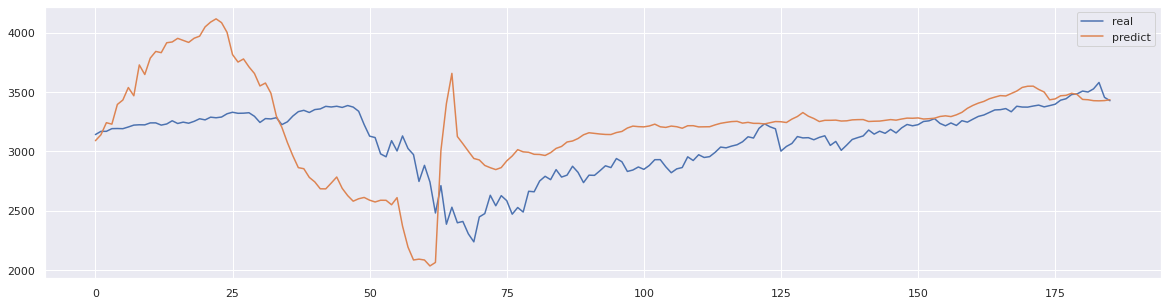

In [ ]:
y_train_pred=model.predict(X_train)
y_test_pred=model.predict(X_test)
print('train rmse:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('test rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)))
plt.figure(figsize=(20,5))
plt.plot(y_test,label='real')
plt.plot(y_test_pred,label='predict')
plt.legend()
plt.show()

In [ ]:
profit(pd.Series(y_test.flatten()),pd.Series(y_test_pred.flatten()))

total buy 149
ratio buy/all test set: 0.8010752688172043
win num 95
lose num 54
revenue 1119.0


In [ ]:
X_train.shape

(186, 7, 4)

In [ ]:
# The GRU architecture
model = Sequential()
# First GRU layer with Dropout regularisation
model.add(GRU(units=50,activation='relu', return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(GRU(units=50, activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(1))
# Compiling the RNN
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 7, 50)             8400      
_________________________________________________________________
gru_5 (GRU)                  (None, 50)                15300     
_________________________________________________________________
dense_16 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 11        
Total params: 24,221
Trainable params: 24,221
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = [EarlyStopping(monitor="val_loss", patience=10, #2 or 1 thoi
                           mode='min',restore_best_weights=True),
            ]
history = model.fit(X_train, y_train, epochs=200, 
                    validation_split=0.2, verbose=1,callbacks=callbacks)

Epoch 1/200
5/5 [==============================] - 0s 70ms/step - loss: 9149590.0000 - val_loss: 11193482.0000
Epoch 2/200
5/5 [==============================] - 0s 11ms/step - loss: 9037584.0000 - val_loss: 11166090.0000
Epoch 3/200
5/5 [==============================] - 0s 10ms/step - loss: 8919076.0000 - val_loss: 11140183.0000
Epoch 4/200
5/5 [==============================] - 0s 10ms/step - loss: 8778515.0000 - val_loss: 11103704.0000
Epoch 5/200
5/5 [==============================] - 0s 11ms/step - loss: 8541043.0000 - val_loss: 11032704.0000
Epoch 6/200
5/5 [==============================] - 0s 11ms/step - loss: 8192505.0000 - val_loss: 10908166.0000
Epoch 7/200
5/5 [==============================] - 0s 11ms/step - loss: 7747425.5000 - val_loss: 10737509.0000
Epoch 8/200
5/5 [==============================] - 0s 10ms/step - loss: 7088471.5000 - val_loss: 10393280.0000
Epoch 9/200
5/5 [==============================] - 0s 10ms/step - loss: 6055491.5000 - val_loss: 9759896.0000
Ep

train rmse: 202.93705887897448
test rmse: 202.93705887897448


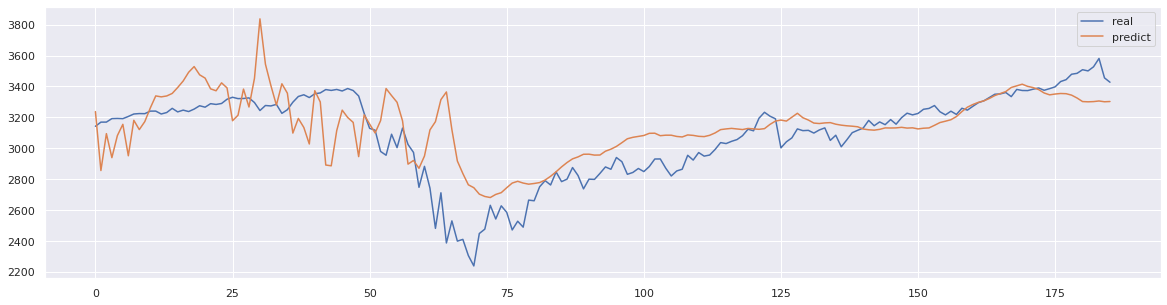

total buy 120
ratio buy/all test set: 0.6451612903225806
win num 74
lose num 46
revenue 794.710205078125


In [ ]:
y_train_pred=model.predict(X_train)
y_test_pred=model.predict(X_test)
print('train rmse:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('test rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)))
plt.figure(figsize=(20,5))
plt.plot(y_test,label='real')
plt.plot(y_test_pred,label='predict')
plt.legend()
plt.show()
profit(pd.Series(y_test.flatten()),pd.Series(y_test_pred.flatten()))

## Try classical ML method (not dynamic model)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate,cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle

# Score:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
#ML normal ML
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.linear_model import TheilSenRegressor, HuberRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures

#ML ensembles
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor

#Special
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [ ]:
from yahoo_fin.stock_info import get_data

stock_code={'Apple':'AAPL', 'Microsoft':'MSFT','Facebook':'Fb','Amazon':'AMZN',
            'Twitter':'TWTR','SP500':'^GSPC'}

df= get_data(stock_code['SP500'],  start_date = '2017-01-01',
                          end_date='2020-09-05',
                      index_as_date = True, interval="1d")
df_sp500=df['adjclose']# Y

df_gld= get_data("GLD",start_date = '2017-01-01',end_date='2020-09-05',
                      index_as_date = True, interval="1d") # Gold price
df_dxy= get_data("UUP",start_date = '2017-01-01',end_date='2020-09-05',
                      index_as_date = True, interval="1d") # Invesco DB US Dollar 
df_ief= get_data("IEF",start_date = '2017-01-01',end_date='2020-09-05',
                      index_as_date = True, interval="1d") # 10 Year Treasury Bond 
df_gush= get_data("GUSH",start_date = '2017-01-01',end_date='2020-09-05',
                      index_as_date = True, interval="1d") # Direxion Daily S&P Oil & Gas Exp. & Prod. Bull 2X Shares
df_assets = pd.DataFrame({
    'GUSH':df_gush['adjclose'],
    'GLD': df_gld['adjclose'],
    'UUP': df_dxy['adjclose'],
    'IEF': df_ief['adjclose'],
})
df_assets              #X

,GUSH,GLD,UUP,IEF
2017-01-03,21088.333984,110.470001,25.873072,97.661842
2017-01-04,21383.804688,110.860001,25.679264,97.773666
2017-01-05,21168.191406,112.580002,25.407936,98.407555
2017-01-06,20679.062500,111.750000,25.592051,97.960114
2017-01-09,19006.050781,112.669998,25.524220,98.332977
...,...,...,...,...
2020-08-31,32.180000,184.830002,24.900000,121.422005
2020-09-01,31.930000,185.050003,24.950001,121.820000
2020-09-02,30.260000,182.619995,25.040001,121.989998
2020-09-03,29.690001,181.139999,25.049999,122.150002


In [ ]:
df_sp500

2017-01-03    2257.830078
2017-01-04    2270.750000
2017-01-05    2269.000000
2017-01-06    2276.979980
2017-01-09    2268.899902
                 ...     
2020-08-31    3500.310059
2020-09-01    3526.649902
2020-09-02    3580.840088
2020-09-03    3455.060059
2020-09-04    3426.959961
Name: adjclose, Length: 926, dtype: float64

In [ ]:
df=df_assets.merge(df_sp500,left_index=True,right_index=True)
df #normal

,GUSH,GLD,UUP,IEF,adjclose
2017-01-03,21088.333984,110.470001,25.873072,97.661842,2257.830078
2017-01-04,21383.804688,110.860001,25.679264,97.773666,2270.750000
2017-01-05,21168.191406,112.580002,25.407936,98.407555,2269.000000
2017-01-06,20679.062500,111.750000,25.592051,97.960114,2276.979980
2017-01-09,19006.050781,112.669998,25.524220,98.332977,2268.899902
...,...,...,...,...,...
2020-08-31,32.180000,184.830002,24.900000,121.422005,3500.310059
2020-09-01,31.930000,185.050003,24.950001,121.820000,3526.649902
2020-09-02,30.260000,182.619995,25.040001,121.989998,3580.840088
2020-09-03,29.690001,181.139999,25.049999,122.150002,3455.060059


Phai adjust y value xuong 1 ngay de X co the du doan duoc tuong lai

In [ ]:
df_assets_shift=df_assets.shift(1)
df_assets_shift

,GUSH,GLD,UUP,IEF
2017-01-03,NaN,NaN,NaN,NaN
2017-01-04,21088.333984,110.470001,25.873072,97.661842
2017-01-05,21383.804688,110.860001,25.679264,97.773666
2017-01-06,21168.191406,112.580002,25.407936,98.407555
2017-01-09,20679.062500,111.750000,25.592051,97.960114
...,...,...,...,...
2020-08-31,34.250000,184.389999,24.930000,121.292091
2020-09-01,32.180000,184.830002,24.900000,121.422005
2020-09-02,31.930000,185.050003,24.950001,121.820000
2020-09-03,30.260000,182.619995,25.040001,121.989998


In [ ]:
new_df=pd.concat([df_assets_shift,df_sp500],axis=1).dropna()
new_df

,GUSH,GLD,UUP,IEF,adjclose
2017-01-04,21088.333984,110.470001,25.873072,97.661842,2270.750000
2017-01-05,21383.804688,110.860001,25.679264,97.773666,2269.000000
2017-01-06,21168.191406,112.580002,25.407936,98.407555,2276.979980
2017-01-09,20679.062500,111.750000,25.592051,97.960114,2268.899902
2017-01-10,19006.050781,112.669998,25.524220,98.332977,2268.899902
...,...,...,...,...,...
2020-08-31,34.250000,184.389999,24.930000,121.292091,3500.310059
2020-09-01,32.180000,184.830002,24.900000,121.422005,3526.649902
2020-09-02,31.930000,185.050003,24.950001,121.820000,3580.840088
2020-09-03,30.260000,182.619995,25.040001,121.989998,3455.060059


In [ ]:
split=int(len(new_df)*0.8)
train=new_df[:split]
test=new_df[split:]
print(train.shape)
print(test.shape)

(740, 5)
(185, 5)


In [ ]:
X_train=train.drop(['adjclose'],axis=1)
y_train=train['adjclose']
X_test=test.drop(['adjclose'],axis=1)
y_test=test['adjclose']
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(740, 4)
(740,)
(185, 4)
(185,)


In [ ]:
#transform=StandardScaler()
transform=RobustScaler()

X_train_trans = transform.fit_transform(X_train)
X_test_trans = transform.fit_transform(X_test)

In [ ]:
# Creating a list of the classifiers
regression = {

    'LR':LinearRegression(),
    'LASSO':Lasso(), 
    'Ridge':Ridge(), 
    'EN':ElasticNet(),
    #'KNN':KNeighborsRegressor(), # kha lau
    #'CART':DecisionTreeRegressor(), 
    #'SVR':SVR(),
    # New , Theil, Huber Regressor:
    'RANSAC':RANSACRegressor(),
    #'TheilSen':TheilSenRegressor(),
    'Huber':HuberRegressor(),
    #New: Poly nominal
    #'Poly2':Pipeline([('Poly2', PolynomialFeatures(degree=2)),
    #                 ('linear', LinearRegression(fit_intercept=False))]),
    
    #Ensemble:
    #'AB':AdaBoostRegressor(), #Bagging (very long)
    #'GBM':GradientBoostingRegressor(),  #Boosting
    #'RF':RandomForestRegressor(), #Boosting
    #'ET':ExtraTreesRegressor(), #Bagging (very long)
    #New from Matt cookbook
    #'XGB':XGBRegressor(), #New Boosting
    'LGBM':LGBMRegressor(), #New Boosting   
}

In [ ]:
#Cross validate
import time
num_folds = 3
seed = 7

scoring = {'mse' : make_scorer(mean_squared_error), 
           'r2' : make_scorer(r2_score),
           }

names = []
train_rmse=[]
train_r2=[]
test_rmse=[]
test_r2=[]
fit_time=[]
time_=[]

for name, model in regression.items():
  print(name)
  start=time.time()
  estimator = model
  cv_results = cross_validate(estimator, X_train, y_train, cv=3, scoring=scoring,
                              return_train_score=True,
                              return_estimator=True
                              )

  # Time :
  time_cal=time.time() - start
  print('time : %0.3f' % (time_cal),'\n')
  
  #results.append(cv_results) # array of values
  names.append(name)
  train_rmse.append(np.sqrt(cv_results['train_mse'].mean()))
  train_r2.append(cv_results['train_r2'].mean())
  

  test_rmse.append(np.sqrt(cv_results['test_mse'].mean()))
  test_r2.append(cv_results['test_r2'].mean())
  

  fit_time.append(cv_results['fit_time'].mean())
  time_.append(time_cal)

  #print(cv_results.keys())
  print("%s: train_mse: %0.2f train_r2: %0.2f \
  test_mse: %0.2f test_r2: %0.2f fit_time: %0.2f" % 
       (name, cv_results['train_mse'].mean(),cv_results['train_r2'].mean(),
       cv_results['test_mse'].mean(),cv_results['test_r2'].mean(),
       cv_results['fit_time'].mean()))


LR
time : 0.021 

LR: train_mse: 10990.53 train_r2: 0.67   test_mse: 884608.75 test_r2: -43.92 fit_time: 0.00
LASSO
time : 0.017 

LASSO: train_mse: 10994.16 train_r2: 0.67   test_mse: 860927.20 test_r2: -42.87 fit_time: 0.00
Ridge
time : 0.016 

Ridge: train_mse: 10990.80 train_r2: 0.67   test_mse: 877137.73 test_r2: -43.61 fit_time: 0.00
EN
time : 0.015 

EN: train_mse: 12744.55 train_r2: 0.62   test_mse: 373966.65 test_r2: -21.82 fit_time: 0.00
RANSAC
time : 0.054 

RANSAC: train_mse: 14995.68 train_r2: 0.54   test_mse: 1272668.11 test_r2: -59.84 fit_time: 0.01
Huber
time : 0.065 

Huber: train_mse: 18690.67 train_r2: 0.43   test_mse: 123924.30 test_r2: -11.46 fit_time: 0.02
LGBM
time : 0.178 

LGBM: train_mse: 382.26 train_r2: 0.99   test_mse: 100829.62 test_r2: -7.77 fit_time: 0.05


In [ ]:
df_results_val=pd.DataFrame(list(zip(names,test_rmse,test_r2,
                                     train_rmse,train_r2,
                                     fit_time,time_)),
                  columns=['Names','test_rmse','test_r2',
                           'train_rmse','train_r2',
                           'fit_time','time'])
df_results_val=df_results_val.sort_values(by='test_rmse',ascending=True)
df_results_val

,Names,test_rmse,test_r2,train_rmse,train_r2,fit_time,time
6,LGBM,317.536799,-7.768033,19.551524,0.987347,0.048600,0.178248
5,Huber,352.028830,-11.462547,136.713825,0.434514,0.018487,0.065358
3,EN,611.528130,-21.821234,112.891768,0.618727,0.002113,0.015181
1,LASSO,927.861626,-42.868060,104.853063,0.670809,0.002622,0.017186
2,Ridge,936.556316,-43.606689,104.837011,0.670917,0.002101,0.015949
0,LR,940.536418,-43.924328,104.835750,0.670925,0.002406,0.021353
4,RANSAC,1128.125929,-59.837748,122.456854,0.535780,0.014690,0.054034


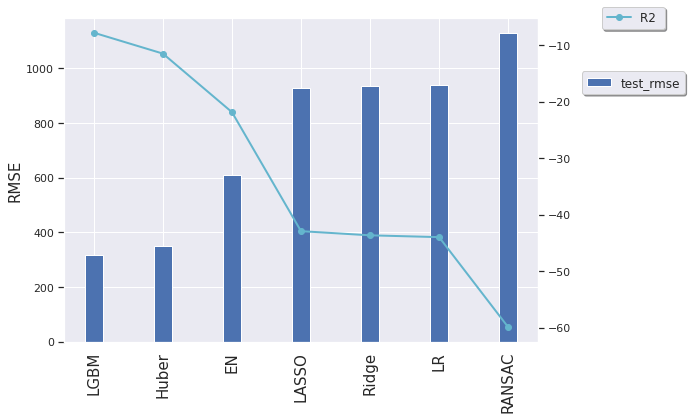

In [ ]:
# Define name:
name=df_results_val['Names']
test_rmse=df_results_val['test_rmse']
test_r2=df_results_val['test_r2']
#time = df_results_val['time']
# Plot:
x = np.arange(len(name))
fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x, test_rmse, color = 'b', width = 0.25,label='test_rmse')
#rects2 = ax.plot(x, test_r2, color = 'g',marker='o',label='test_r2')

ax2 = ax.twinx()
ax2.plot(x,test_r2,color ='c',marker='o',lw=2,label='R2 ')
ax2.secondary_yaxis('right')

ax.set_xticks(x)
ax.set_xticklabels(name,fontsize=15,rotation=90)
ax.set_ylabel('RMSE',fontsize=15)
ax2.set_ylabel('R2',fontsize=15)
#plt.gca().legend(loc ='center',bbox_to_anchor=(0.5, -0.2))
legend1=ax.legend(loc='center',bbox_to_anchor=(1.2, 0.8),shadow=True, fontsize='medium')
legend2=ax2.legend(loc='center',bbox_to_anchor=(1.2,1),shadow=True, fontsize='medium')

plt.axis('off')
fig.tight_layout()
plt.show()

In [ ]:
#Cross validate
import time
num_folds = 3
seed = 7

scoring = {'mse' : make_scorer(mean_squared_error), 
           'r2' : make_scorer(r2_score),
           }

names = []
train_rmse=[]
train_r2=[]
test_rmse=[]
test_r2=[]
fit_time=[]
time_=[]

for name, model in regression.items():
  print(name)
  start=time.time()
  estimator = model
  cv_results = cross_validate(estimator, X_train_trans, y_train, cv=3, scoring=scoring,
                              return_train_score=True,
                              return_estimator=True
                              )

  # Time :
  time_cal=time.time() - start
  print('time : %0.3f' % (time_cal),'\n')
  
  #results.append(cv_results) # array of values
  names.append(name)
  train_rmse.append(np.sqrt(cv_results['train_mse'].mean()))
  train_r2.append(cv_results['train_r2'].mean())
  

  test_rmse.append(np.sqrt(cv_results['test_mse'].mean()))
  test_r2.append(cv_results['test_r2'].mean())
  

  fit_time.append(cv_results['fit_time'].mean())
  time_.append(time_cal)

  #print(cv_results.keys())
  print("%s: train_mse: %0.2f train_r2: %0.2f \
  test_mse: %0.2f test_r2: %0.2f fit_time: %0.2f" % 
       (name, cv_results['train_mse'].mean(),cv_results['train_r2'].mean(),
       cv_results['test_mse'].mean(),cv_results['test_r2'].mean(),
       cv_results['fit_time'].mean()))


LR
time : 0.017 

LR: train_mse: 10990.53 train_r2: 0.67   test_mse: 884608.75 test_r2: -43.92 fit_time: 0.00
LASSO
time : 0.012 

LASSO: train_mse: 11035.99 train_r2: 0.67   test_mse: 813984.85 test_r2: -40.58 fit_time: 0.00
Ridge
time : 0.009 

Ridge: train_mse: 10997.76 train_r2: 0.67   test_mse: 844303.53 test_r2: -42.15 fit_time: 0.00
EN
time : 0.012 

EN: train_mse: 18214.27 train_r2: 0.46   test_mse: 141059.71 test_r2: -9.56 fit_time: 0.00
RANSAC
time : 0.057 

RANSAC: train_mse: 17802.48 train_r2: 0.46   test_mse: 1247737.37 test_r2: -59.33 fit_time: 0.02
Huber
time : 0.027 

Huber: train_mse: 11445.34 train_r2: 0.66   test_mse: 961630.59 test_r2: -47.38 fit_time: 0.01
LGBM
time : 0.140 

LGBM: train_mse: 390.32 train_r2: 0.99   test_mse: 101099.25 test_r2: -7.84 fit_time: 0.04


In [ ]:
df_results_val=pd.DataFrame(list(zip(names,test_rmse,test_r2,
                                     train_rmse,train_r2,
                                     fit_time,time_)),
                  columns=['Names','test_rmse','test_r2',
                           'train_rmse','train_r2',
                           'fit_time','time'])
df_results_val=df_results_val.sort_values(by='test_rmse',ascending=True)
df_results_val

,Names,test_rmse,test_r2,train_rmse,train_r2,fit_time,time
6,LGBM,317.961078,-7.838281,19.756503,0.987074,0.040440,0.139568
3,EN,375.579162,-9.562000,134.960264,0.456175,0.001488,0.011692
1,LASSO,902.211089,-40.577699,105.052297,0.669537,0.001484,0.012203
2,Ridge,918.859906,-42.146496,104.870217,0.670695,0.000992,0.009272
0,LR,940.536418,-43.924328,104.835750,0.670925,0.002101,0.016741
5,Huber,980.627653,-47.382758,106.982898,0.657197,0.007158,0.027492
4,RANSAC,1117.021651,-59.326058,133.425919,0.460582,0.016340,0.056961


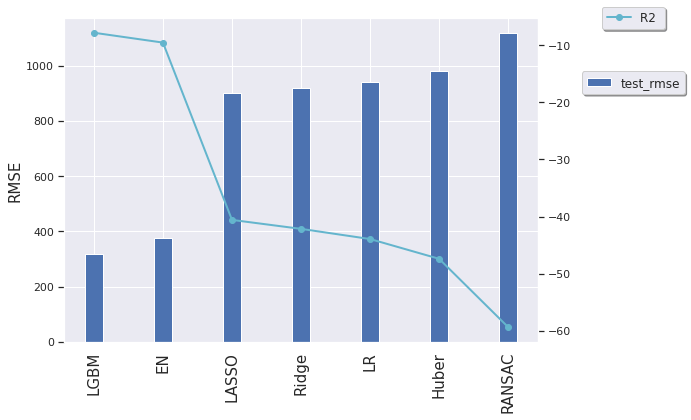

In [ ]:
# Define name:
name=df_results_val['Names']
test_rmse=df_results_val['test_rmse']
test_r2=df_results_val['test_r2']
#time = df_results_val['time']
# Plot:
x = np.arange(len(name))
fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x, test_rmse, color = 'b', width = 0.25,label='test_rmse')
#rects2 = ax.plot(x, test_r2, color = 'g',marker='o',label='test_r2')

ax2 = ax.twinx()
ax2.plot(x,test_r2,color ='c',marker='o',lw=2,label='R2 ')
ax2.secondary_yaxis('right')

ax.set_xticks(x)
ax.set_xticklabels(name,fontsize=15,rotation=90)
ax.set_ylabel('RMSE',fontsize=15)
ax2.set_ylabel('R2',fontsize=15)
#plt.gca().legend(loc ='center',bbox_to_anchor=(0.5, -0.2))
legend1=ax.legend(loc='center',bbox_to_anchor=(1.2, 0.8),shadow=True, fontsize='medium')
legend2=ax2.legend(loc='center',bbox_to_anchor=(1.2,1),shadow=True, fontsize='medium')

plt.axis('off')
fig.tight_layout()
plt.show()

train rmse: 20.078821395435554
test rmse: 320.2154088135086


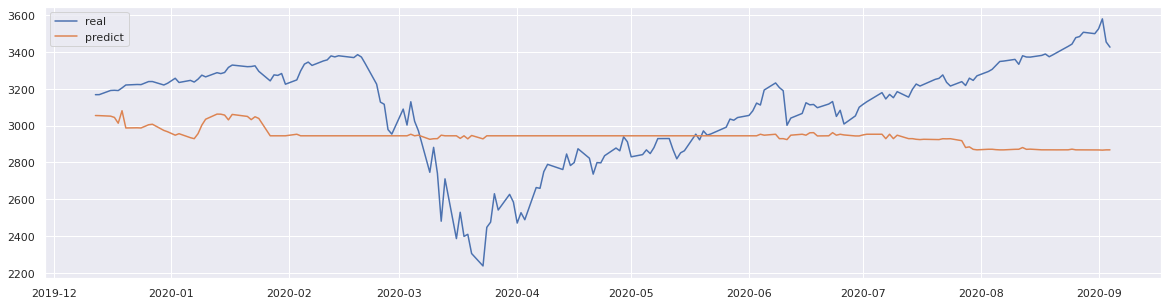

In [ ]:
model=LGBMRegressor()
model.fit(X_train,y_train)
y_train_pred=model.predict(X_train)
y_test_pred=model.predict(X_test)
y_test_pred=pd.Series(y_test_pred)
y_test_pred.index=y_test.index
print('train rmse:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('test rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)))
plt.figure(figsize=(20,5))
plt.plot(y_test,label='real')
plt.plot(y_test_pred,label='predict')
plt.legend()
plt.show()

In [ ]:
profit(y_test,
       y_test_pred)

total buy 50
ratio buy/all test set: 0.2702702702702703
win num 28
lose num 22
revenue 256.02001953125


# 2.Predicting trends with classification based ML

## Prepare Data

In [ ]:
!pip install yahoo_fin
!pip install requests_html

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import mean_squared_error
#import yfinance as yf
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode
from sklearn.metrics import classification_report

In [ ]:
from yahoo_fin.stock_info import get_data

stock_code={'Apple':'AAPL', 'Microsoft':'MSFT','Facebook':'Fb','Amazon':'AMZN',
            'Twitter':'TWTR','SP500':'^GSPC'}

df= get_data(stock_code['SP500'],  start_date = '2016-01-01',
                          end_date='2020-09-05',
                      index_as_date = True, interval="1d")
df_sp500=df['adjclose']# Y

df_gld= get_data("GLD",start_date = '2016-01-01',end_date='2020-09-05',
                      index_as_date = True, interval="1d") # Gold price
df_dxy= get_data("UUP",start_date = '2016-01-01',end_date='2020-09-05',
                      index_as_date = True, interval="1d") # Invesco DB US Dollar 
df_ief= get_data("IEF",start_date = '2016-01-01',end_date='2020-09-05',
                      index_as_date = True, interval="1d") # 10 Year Treasury Bond 
df_gush= get_data("GUSH",start_date = '2016-01-01',end_date='2020-09-05',
                      index_as_date = True, interval="1d") # Direxion Daily S&P Oil & Gas Exp. & Prod. Bull 2X Shares
df_assets = pd.DataFrame({
    'GUSH':df_gush['adjclose'],
    'GLD': df_gld['adjclose'],
    'UUP': df_dxy['adjclose'],
    'IEF': df_ief['adjclose'],
})
df_assets              #X

,GUSH,GLD,UUP,IEF
2016-01-04,13072.905273,102.889999,24.894354,97.151749
2016-01-05,12937.333984,103.180000,25.039707,97.124275
2016-01-06,10225.916992,104.669998,24.971874,97.710609
2016-01-07,9538.379883,106.150002,24.719925,97.921371
2016-01-08,9571.303711,105.680000,24.768377,98.168747
...,...,...,...,...
2020-08-31,32.180000,184.830002,24.900000,121.422005
2020-09-01,31.930000,185.050003,24.950001,121.820000
2020-09-02,30.260000,182.619995,25.040001,121.989998
2020-09-03,29.690001,181.139999,25.049999,122.150002


In [ ]:
y = df_sp500.pct_change().dropna()
y_direction = y >= 0

In [ ]:
y_direction

2016-01-05     True
2016-01-06    False
2016-01-07    False
2016-01-08    False
2016-01-11     True
              ...  
2020-08-31    False
2020-09-01     True
2020-09-02     True
2020-09-03    False
2020-09-04    False
Name: adjclose, Length: 1177, dtype: bool

In [ ]:
flags = list(y_direction.unique())
flags.sort()
print(flags)

[False, True]


In [ ]:
df_input=df_assets

In [ ]:
from sklearn.linear_model import LinearRegression

class LinearRegressionModel(object):
    def __init__(self):
        self.df_result = pd.DataFrame(columns=['Actual', 'Predicted'])

    def get_model(self):
        return LinearRegression(fit_intercept=False)

    def learn(self, df, ys, start_date, end_date, lookback_period=20):
        model = self.get_model()

        for date in df[start_date:end_date].index:
            # Fit the model
            x = self.get_prices_since(df, date, lookback_period)
            y = self.get_prices_since(ys, date, lookback_period)
            model.fit(x, y.ravel())
            # Predict the current period
            x_current = df.loc[date].values
            [y_pred] = model.predict([x_current])
            # Store predictions
            new_index = pd.to_datetime(date, format='%Y-%m-%d')
            y_actual = ys.loc[date]
            self.df_result.loc[new_index] = [y_actual, y_pred]

    def get_prices_since(self, df, date_since, lookback):

        index = df.index.get_loc(date_since) # current date
        return df.iloc[index-lookback:index] #current date - 20 : current date


## Check all ML model

In [ ]:
from sklearn.metrics import log_loss 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score,balanced_accuracy_score
from sklearn.metrics import average_precision_score 
from sklearn.pipeline import Pipeline


#ML normal ML
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

#ML ensembles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

#Special
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [ ]:
from sklearn.linear_model import LogisticRegression

class LogisticRegressionModel(LinearRegressionModel):
    def get_model(self):
        return LogisticRegression(solver='lbfgs')
logistic_reg_model = LogisticRegressionModel()
logistic_reg_model.learn(df_input, y_direction, start_date='2017', 
                         end_date='2020', lookback_period=100)

In [ ]:
logistic_reg_model.df_result.head()

,Actual,Predicted
2017-01-03,True,True
2017-01-04,True,True
2017-01-05,False,True
2017-01-06,True,True
2017-01-09,False,True


In [ ]:
logistic_reg_model.df_result.Predicted.value_counts()

True     596
False    330
Name: Predicted, dtype: int64

In [ ]:
df_result = logistic_reg_model.df_result    
actual = list(df_result['Actual'])
predicted = list(df_result['Predicted'])

print(classification_report(actual, predicted))

              precision    recall  f1-score   support

       False       0.45      0.37      0.40       399
        True       0.58      0.65      0.61       527

    accuracy                           0.53       926
   macro avg       0.51      0.51      0.51       926
weighted avg       0.52      0.53      0.52       926



In [ ]:
from sklearn.svm import SVC

class SVCModel(LogisticRegressionModel):
    def get_model(self):
        return SVC(C=0.001, gamma='auto') #C=1000
svc_model = SVCModel()
svc_model.learn(df_input, y_direction, start_date='2017', 
                end_date='2020', lookback_period=100)
df_result = svc_model.df_result
actual = list(df_result['Actual'])
predicted = list(df_result['Predicted'])
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

       False       0.39      0.07      0.12       399
        True       0.57      0.92      0.70       527

    accuracy                           0.55       926
   macro avg       0.48      0.49      0.41       926
weighted avg       0.49      0.55      0.45       926



In [ ]:
class LGBMClassifier_model(LinearRegressionModel):
    def get_model(self):
        return LGBMClassifier()

model = LGBMClassifier_model()
model.learn(df_input, y_direction, start_date='2017', 
                end_date='2020', lookback_period=100)
df_result = model.df_result
actual = list(df_result['Actual'])
predicted = list(df_result['Predicted'])
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

       False       0.41      0.34      0.37       399
        True       0.56      0.64      0.60       527

    accuracy                           0.51       926
   macro avg       0.49      0.49      0.48       926
weighted avg       0.50      0.51      0.50       926



#3.Indicator chart and analyse

Have you tried following instructions from here?

https://github.com/mrjbq7/ta-lib

And change any sudo apt-get to just !apt. Any cd to %cd

Update: try this

!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
import talib

In [ ]:
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
import talib

Selecting previously unselected package libta-lib0.
(Reading database ... 144579 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
/sbin/ldconfig.real: /usr/local/lib/python3.6/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 266kB 2.8MB/s 
  Created wheel for ta-lib: filename=TA_Lib-0.4.18-cp36-cp36m-linux_x86_64.whl size=1531852 sha256=5cd4512b1913338fbf8a41e1702d44dd49defeaaa8bc14c16b14aa092ac979e1
  Stored in directory: /root/.cache/pip/wheels/11/cc/88/20dc42c28a07efb297dad4303948ef6dd4a3c7257553db8f09
Successfully built ta-lib


In [ ]:
!pip install mplfinance

     |████████████████████████████████| 61kB 1.9MB/s 


In [ ]:
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import talib
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
from matplotlib.pylab import date2num

In [ ]:
!pip install yahoo_fin
!pip install requests_html

     |████████████████████████████████| 153kB 6.5MB/s 
     |████████████████████████████████| 133kB 12.2MB/s 
     |████████████████████████████████| 71kB 5.8MB/s 
     |████████████████████████████████| 81kB 6.1MB/s 
  Created wheel for parse: filename=parse-1.17.0-cp36-none-any.whl size=24118 sha256=dafbafc7f89109826dac54432a5f0c07e6b8bfd31a58183380cde20992be669d
  Stored in directory: /root/.cache/pip/wheels/83/ad/41/87f17d17fdc2b5f9648e2ec2f9dbe6ad51c2f58f086baafedf
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-cp36-none-any.whl size=13485 sha256=380970b3b83b91adde0239a2e7a2a57c6cb2db3ac3ae7a2452681893579ca76f
  Stored in directory: /root/.cache/pip/wheels/5e/63/09/d1dc15179f175357d3f5c00cbffbac37f9e8690d80545143ff
Successfully built parse fake-useragent
ERROR: kaggle 1.5.6 has requirement urllib3<1.25,>=1.21.1, but you'll have urllib3 1.25.10 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is 

In [ ]:
from yahoo_fin.stock_info import get_data

stock_code={'Apple':'AAPL', 'Microsoft':'MSFT','Facebook':'Fb','Amazon':'AMZN',
            'Twitter':'TWTR','SP500':'^GSPC'}

df= get_data(stock_code['SP500'],  start_date = '2016-01-01',
                          end_date='2020-09-05',
                      index_as_date = True, interval="1d")
df

,open,high,low,close,adjclose,volume,ticker
2016-01-04,2038.199951,2038.199951,1989.680054,2012.660034,2012.660034,4304880000,^GSPC
2016-01-05,2013.780029,2021.939941,2004.170044,2016.709961,2016.709961,3706620000,^GSPC
2016-01-06,2011.709961,2011.709961,1979.050049,1990.260010,1990.260010,4336660000,^GSPC
2016-01-07,1985.319946,1985.319946,1938.829956,1943.089966,1943.089966,5076590000,^GSPC
2016-01-08,1945.969971,1960.400024,1918.459961,1922.030029,1922.030029,4664940000,^GSPC
...,...,...,...,...,...,...,...
2020-08-31,3509.729980,3514.770020,3493.250000,3500.310059,3500.310059,4342290000,^GSPC
2020-09-01,3507.439941,3528.030029,3494.600098,3526.649902,3526.649902,4083110000,^GSPC
2020-09-02,3543.760010,3588.110107,3535.229980,3580.840088,3580.840088,4285190000,^GSPC
2020-09-03,3564.739990,3564.850098,3427.409912,3455.060059,3455.060059,4898680000,^GSPC


In [ ]:
def get_indicators(data):
    # Get MACD
    data["macd"], data["macd_signal"], data["macd_hist"] = talib.MACD(data['close'])
    
    # Get MA10 and MA30
    data["ma10"] = talib.MA(data["close"], timeperiod=10)
    data["ma30"] = talib.MA(data["close"], timeperiod=30)
    
    # Get RSI
    data["rsi"] = talib.RSI(data["close"])
    return data

In [ ]:
nflx_df2 = get_indicators(df)
nflx_df2

,open,high,low,close,adjclose,volume,ticker,macd,macd_signal,macd_hist,ma10,ma30,rsi
2016-01-04,2038.199951,2038.199951,1989.680054,2012.660034,2012.660034,4304880000,^GSPC,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,2013.780029,2021.939941,2004.170044,2016.709961,2016.709961,3706620000,^GSPC,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06,2011.709961,2011.709961,1979.050049,1990.260010,1990.260010,4336660000,^GSPC,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-07,1985.319946,1985.319946,1938.829956,1943.089966,1943.089966,5076590000,^GSPC,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-08,1945.969971,1960.400024,1918.459961,1922.030029,1922.030029,4664940000,^GSPC,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,3509.729980,3514.770020,3493.250000,3500.310059,3500.310059,4342290000,^GSPC,64.408822,58.016522,6.392299,3439.380029,3348.138338,76.926975
2020-09-01,3507.439941,3528.030029,3494.600098,3526.649902,3526.649902,4083110000,^GSPC,66.690588,59.751335,6.939253,3453.067017,3357.116667,79.187926
2020-09-02,3543.760010,3588.110107,3535.229980,3580.840088,3580.840088,4285190000,^GSPC,72.041154,62.209299,9.831855,3473.666016,3367.277336,82.900410
2020-09-03,3564.739990,3564.850098,3427.409912,3455.060059,3455.060059,4898680000,^GSPC,65.378477,62.843135,2.535342,3480.621021,3374.590674,57.335327


In [ ]:
def plot_chart(data, n, ticker):
    
    # Filter number of observations to plot
    data = data.iloc[-n:]
    
    # Create figure and set axes for subplots
    fig = plt.figure()
    fig.set_size_inches((20, 16))
    ax_candle = fig.add_axes((0, 0.72, 1, 0.32))
    ax_macd = fig.add_axes((0, 0.48, 1, 0.2), sharex=ax_candle)
    ax_rsi = fig.add_axes((0, 0.24, 1, 0.2), sharex=ax_candle)
    ax_vol = fig.add_axes((0, 0, 1, 0.2), sharex=ax_candle)
    
    # Format x-axis ticks as dates
    ax_candle.xaxis_date()
    
    # Get nested list of date, open, high, low and close prices
    ohlc = []
    for date, row in data.iterrows():
        openp, highp, lowp, closep = row[:4]
        ohlc.append([date2num(date), openp, highp, lowp, closep])
 
    # Plot candlestick chart
    ax_candle.plot(data.index, data["ma10"], label="MA10")
    ax_candle.plot(data.index, data["ma30"], label="MA30")
    candlestick_ohlc(ax_candle, ohlc, colorup="g", colordown="r", width=0.8)
    ax_candle.legend()
    
    # Plot MACD
    ax_macd.plot(data.index, data["macd"], label="macd")
    ax_macd.bar(data.index, data["macd_hist"] * 3, label="hist")
    ax_macd.plot(data.index, data["macd_signal"], label="signal")
    ax_macd.legend()
    
    # Plot RSI
    # Above 70% = overbought, below 30% = oversold
    ax_rsi.set_ylabel("(%)")
    ax_rsi.plot(data.index, [70] * len(data.index), label="overbought")
    ax_rsi.plot(data.index, [30] * len(data.index), label="oversold")
    ax_rsi.plot(data.index, data["rsi"], label="rsi")
    ax_rsi.legend()
    
    # Show volume in millions
    ax_vol.bar(data.index, data["volume"] / 1000000)
    ax_vol.set_ylabel("(Million)")
   
    # Save the chart as PNG
    #fig.savefig("charts/" + ticker + ".png", bbox_inches="tight")
    
    plt.show()

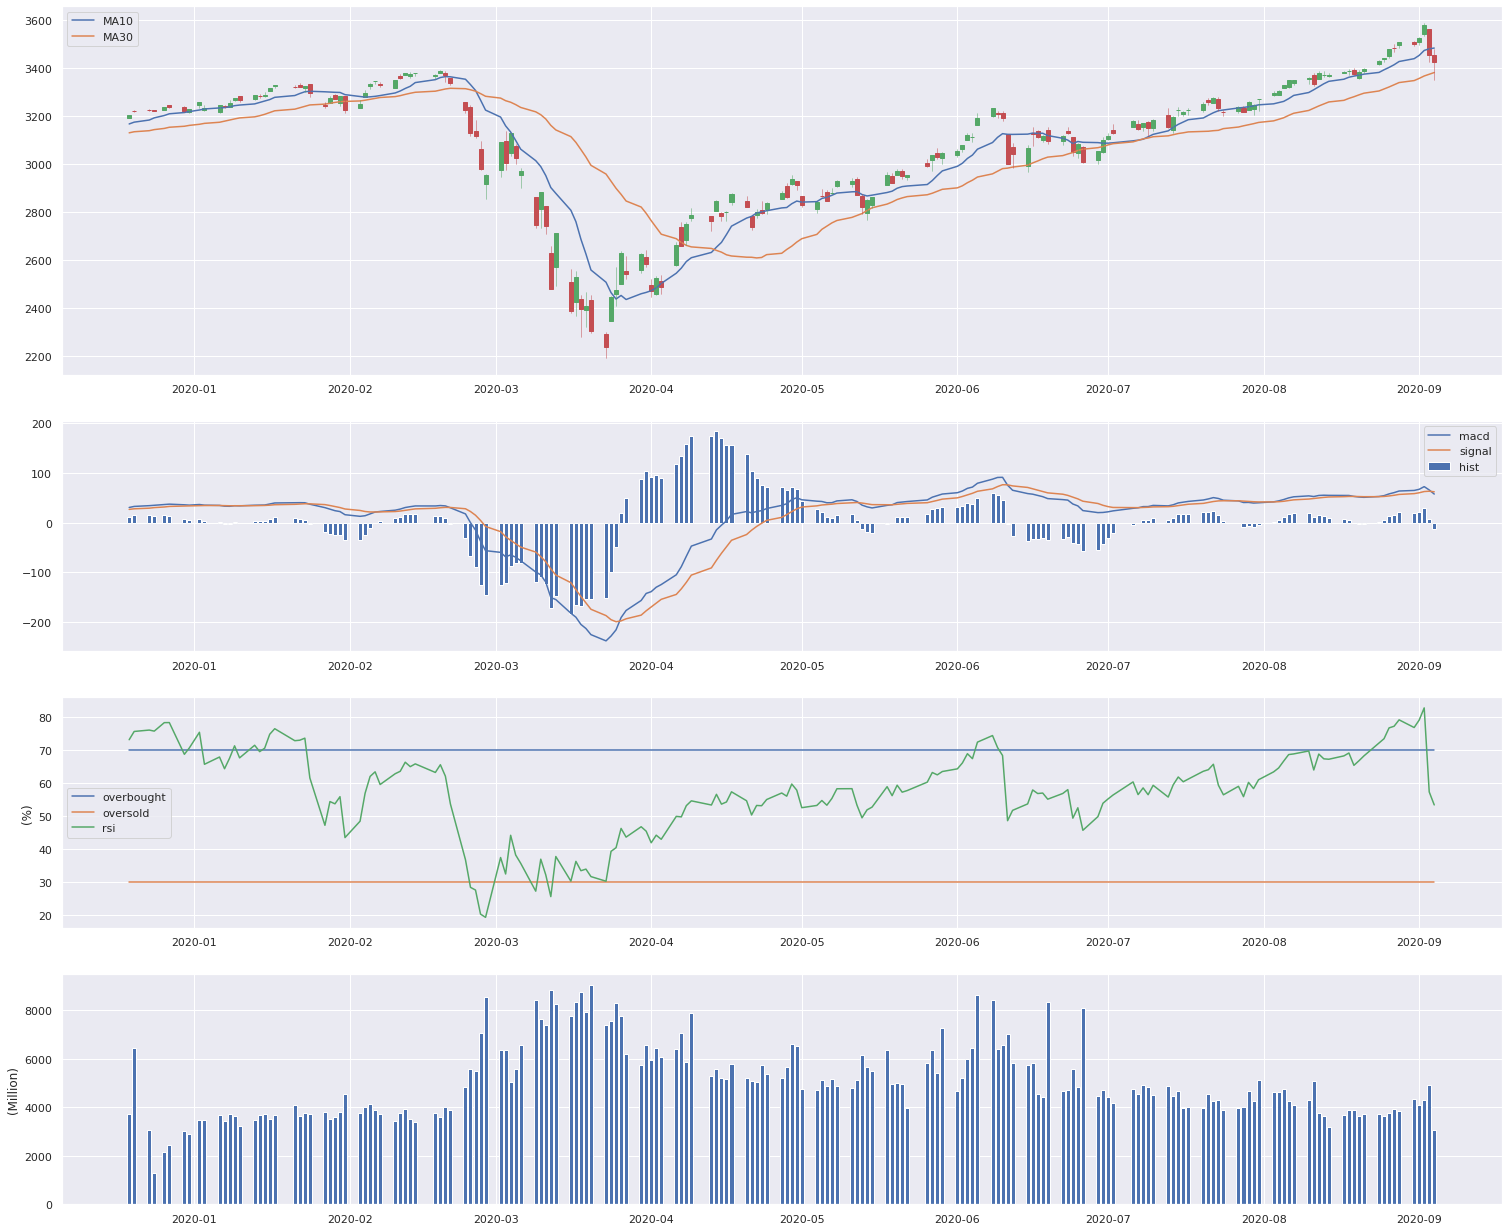

In [ ]:
plot_chart(df, 180, "SP500")

## Buil model and analyze like header 1

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
#ML normal ML
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import TheilSenRegressor, HuberRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
#ML ensembles
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
#Special
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [ ]:
df_indicator=nflx_df2
df_indicator

,open,high,low,close,adjclose,volume,ticker,macd,macd_signal,macd_hist,ma10,ma30,rsi
2016-01-04,2038.199951,2038.199951,1989.680054,2012.660034,2012.660034,4304880000,^GSPC,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,2013.780029,2021.939941,2004.170044,2016.709961,2016.709961,3706620000,^GSPC,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06,2011.709961,2011.709961,1979.050049,1990.260010,1990.260010,4336660000,^GSPC,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-07,1985.319946,1985.319946,1938.829956,1943.089966,1943.089966,5076590000,^GSPC,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-08,1945.969971,1960.400024,1918.459961,1922.030029,1922.030029,4664940000,^GSPC,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,3509.729980,3514.770020,3493.250000,3500.310059,3500.310059,4342290000,^GSPC,64.408822,58.016522,6.392299,3439.380029,3348.138338,76.926975
2020-09-01,3507.439941,3528.030029,3494.600098,3526.649902,3526.649902,4083110000,^GSPC,66.690588,59.751335,6.939253,3453.067017,3357.116667,79.187926
2020-09-02,3543.760010,3588.110107,3535.229980,3580.840088,3580.840088,4285190000,^GSPC,72.041154,62.209299,9.831855,3473.666016,3367.277336,82.900410
2020-09-03,3564.739990,3564.850098,3427.409912,3455.060059,3455.060059,4898680000,^GSPC,65.378477,62.843135,2.535342,3480.621021,3374.590674,57.335327


In [ ]:
df_indicator=df_indicator.drop(['ticker'],axis=1)

In [ ]:
df_indicator.dropna(inplace=True)
df_indicator

,open,high,low,close,adjclose,volume,macd,macd_signal,macd_hist,ma10,ma30,rsi
2016-02-22,1924.439941,1946.699951,1924.439941,1945.500000,1945.500000,4054710000,-2.568857,-14.173489,11.604632,1885.487976,1896.531991,54.182943
2016-02-23,1942.380005,1942.380005,1919.439941,1921.270020,1921.270020,3890650000,-0.981220,-11.535035,10.553815,1892.270984,1896.506657,49.673421
2016-02-24,1917.560059,1932.079956,1891.000000,1929.800049,1929.800049,4317250000,0.954295,-9.037169,9.991464,1900.029993,1896.710990,51.212836
2016-02-25,1931.869995,1951.829956,1925.410034,1951.699951,1951.699951,4118210000,4.206850,-6.388365,10.595215,1910.013989,1897.144987,55.017191
2016-02-26,1954.949951,1962.959961,1945.780029,1948.050049,1948.050049,4348510000,6.416046,-3.827483,10.243529,1921.910999,1899.070654,54.257807
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,3509.729980,3514.770020,3493.250000,3500.310059,3500.310059,4342290000,64.408822,58.016522,6.392299,3439.380029,3348.138338,76.926975
2020-09-01,3507.439941,3528.030029,3494.600098,3526.649902,3526.649902,4083110000,66.690588,59.751335,6.939253,3453.067017,3357.116667,79.187926
2020-09-02,3543.760010,3588.110107,3535.229980,3580.840088,3580.840088,4285190000,72.041154,62.209299,9.831855,3473.666016,3367.277336,82.900410
2020-09-03,3564.739990,3564.850098,3427.409912,3455.060059,3455.060059,4898680000,65.378477,62.843135,2.535342,3480.621021,3374.590674,57.335327


In [ ]:
x=df_indicator.iloc[:,6:]
y=df_indicator['adjclose']
print(x.shape)
print(y.shape)

(1145, 6)
(1145,)


In [ ]:
from sklearn.linear_model import LinearRegression

class LinearRegressionModel(object):
    def __init__(self):
        self.df_result = pd.DataFrame(columns=['Actual', 'Predicted'])

    def get_model(self):
        return LinearRegression(fit_intercept=False)

    def learn(self, df, ys, start_date, end_date, lookback_period=20):
        model = self.get_model()
        #print('++def learn')
        #print('start_date',start_date)
        #print('end_date',start_date)
        #print('lookback_period',lookback_period)
        for date in df[start_date:end_date].index:
            # Fit the model
            x = self.get_prices_since(df, date, lookback_period)
            y = self.get_prices_since(ys, date, lookback_period)
            #print('----date',date)
            #print('x',x)
            #print('y',y)
            #print('y.ravel()',y.ravel())
            #print('x.shape',x.shape)
            #print('y.ravel().shape',y.ravel().shape)
            model.fit(x, y.ravel())
            #print('model.predict(x)',model.predict(x))
            # Predict the current period
            #print('Predict the current period')
            #print('date ',date)
            x_current = df.loc[date].values
            [y_pred] = model.predict([x_current])
            #print('x_current',x_current)
            #print('[y_pred]',[y_pred])

            # Store predictions
            new_index = pd.to_datetime(date, format='%Y-%m-%d')
            y_actual = ys.loc[date]
            #print('y_actual',y_actual)
            self.df_result.loc[new_index] = [y_actual, y_pred]

    def get_prices_since(self, df, date_since, lookback):

        index = df.index.get_loc(date_since) # current date
        #print('++def get_prices_since')
        #print('date_since',date_since)
        #print('index',index)
        #print('index-lookback:index',index-lookback,index) 
        return df.iloc[index-lookback:index] #current date - 20 : current date


In [ ]:
model = LinearRegressionModel()
model.learn(x, y, start_date='2017', 
                       end_date='2020', lookback_period=10)

In [ ]:
def profit(true,predict):
  buy=0
  win=0
  lose=0
  revenue=[]
  for i in range(len(predict)-1):
    if predict.values[i+1] > true.values[i]:
      buy+=1
      result=true.values[i+1]-true.values[i]
      revenue.append(result)
      if result >0:
        win+=1
      else:
        lose+=1
  print('total buy',buy)      
  print('ratio buy/all test set:',buy/len(predict))      
  print('win num',win)
  print('lose num',lose)
  print('revenue',sum(revenue))

test rmse: 24.42831055848921
total buy 115
ratio buy/all test set: 0.6182795698924731
win num 108
lose num 7
revenue 4010.890625


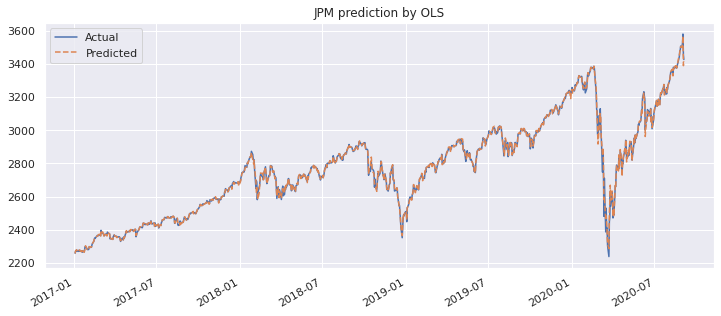

In [ ]:
model.df_result.plot(
    title='JPM prediction by OLS', 
    style=['-', '--'], figsize=(12,5));
y_test=model.df_result.Actual[-186:]
y_test_pred=model.df_result.Predicted[-186:]
print('test rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)))
profit(y_test,y_test_pred)

test rmse: 26.955836888638768
total buy 115
ratio buy/all test set: 0.6182795698924731
win num 109
lose num 6
revenue 3958.0205078125


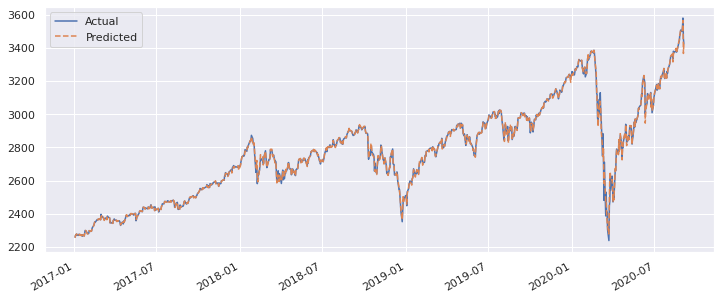

In [ ]:
# class Ridge kế thừa tất cả thuộc tính của class Linear, chỉ thay đổi get_model method
class RidgeRegressionModel(LinearRegressionModel):        
    def get_model(self):
        return Ridge(alpha=.5)
model = RidgeRegressionModel()
model.learn(x, y, start_date='2017', 
                       end_date='2020', lookback_period=10)

model.df_result.plot(
    #title='JPM prediction by OLS', 
    style=['-', '--'], figsize=(12,5));

y_test=model.df_result.Actual[-186:]
y_test_pred=model.df_result.Predicted[-186:]
print('test rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)))
profit(y_test,y_test_pred)

test rmse: 57.88714799596407
total buy 78
ratio buy/all test set: 0.41935483870967744
win num 66
lose num 12
revenue 2128.741455078125


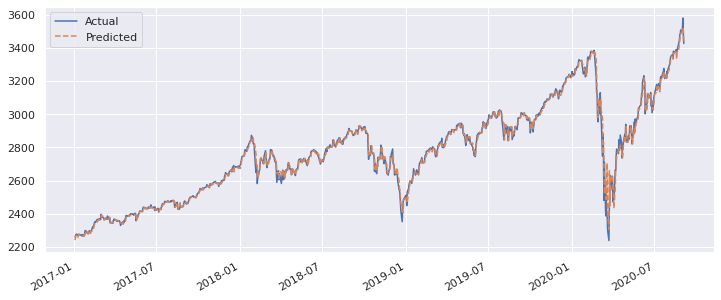

In [ ]:
class GradientBoostingRegressor_model(LinearRegressionModel):        
    def get_model(self):
        return GradientBoostingRegressor()
model = GradientBoostingRegressor_model()
model.learn(x, y, start_date='2017', 
                       end_date='2020', lookback_period=10)

model.df_result.plot(
    #title='JPM prediction by OLS', 
    style=['-', '--'], figsize=(12,5));

y_test=model.df_result.Actual[-186:]
y_test_pred=model.df_result.Predicted[-186:]
print('test rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)))
profit(y_test,y_test_pred)

## LSTM model (not dynamic)

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import mean_squared_error
# univariate mlp example
import warnings
from numpy import array
import matplotlib.pyplot as plt
from keras import optimizers
from keras import backend
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM,GRU, RepeatVector, TimeDistributed, Flatten,Bidirectional
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l1
from keras.regularizers import l2
from keras.regularizers import l1_l2
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Dense
from keras.metrics import categorical_crossentropy

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [ ]:
df=df_indicator

In [ ]:
split_number=0.80
split=int(len(df) * split_number)
train_set=df[:split]
test_set=df[split:]
predict_future=len(test_set)
print(train_set.shape,test_set.shape)

(916, 12) (229, 12)


In [ ]:
# split a univariate sequence into samples
def split_sequence(X,y,n_steps_in, n_steps_out):
  X_prepare, y_prepare = list(), list()
  for i in range(len(X)):
    #if i==5: 
    #  break
    # find the end of this pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    # check if we are beyond the sequence
    if out_end_ix > len(X):
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = X[i:end_ix], y[end_ix:out_end_ix]
    X_prepare.append(seq_x)
    y_prepare.append(seq_y)
  #return X_prepare,y_prepare
  return np.array([np.array(X) for X in X_prepare]), np.array([np.array(y) for y in y_prepare])

In [ ]:
X=train_set.iloc[:,6:]
y=train_set['adjclose']

In [ ]:
n_steps_in  = 5
n_steps_out = 1
X_train, y_train = split_sequence(X,y, n_steps_in, n_steps_out)
print(X_train.shape)
print(y_train.shape)
#prepare test set
inputs=df[len(df)-len(test_set) - n_steps_in:]
X=inputs.iloc[:,6:]
y=inputs['adjclose']
X_test, y_test = split_sequence(X,y, n_steps_in, n_steps_out)
print(X_test.shape)
print(y_test.shape)

(231, 5, 6)
(231, 1)
(229, 5, 6)
(229, 1)


In [ ]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(None, X_train.shape[2]))) # 7 timesteps, 4 feature
model.add(Dense(10,activation='relu'))
model.add(Dense(1)) # one timestep
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 50)                11400     
_________________________________________________________________
dense_12 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 11        
Total params: 11,921
Trainable params: 11,921
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = [EarlyStopping(monitor="val_loss", patience=10, #2 or 1 thoi
                           mode='min',restore_best_weights=True),
            ]
history = model.fit(X_train, y_train, epochs=200, 
                    validation_split=0.2, verbose=1,callbacks=callbacks)

Epoch 1/200
6/6 [==============================] - 0s 35ms/step - loss: 4418537.5000 - val_loss: 4458071.5000
Epoch 2/200
6/6 [==============================] - 0s 8ms/step - loss: 3157479.7500 - val_loss: 1533679.6250
Epoch 3/200
6/6 [==============================] - 0s 7ms/step - loss: 1236546.3750 - val_loss: 803613.0000
Epoch 4/200
6/6 [==============================] - 0s 6ms/step - loss: 496753.9062 - val_loss: 340151.2188
Epoch 5/200
6/6 [==============================] - 0s 6ms/step - loss: 184313.2656 - val_loss: 88611.1562
Epoch 6/200
6/6 [==============================] - 0s 5ms/step - loss: 53314.3008 - val_loss: 1118.0562
Epoch 7/200
6/6 [==============================] - 0s 5ms/step - loss: 31263.3594 - val_loss: 1358.3282
Epoch 8/200
6/6 [==============================] - 0s 6ms/step - loss: 35970.6016 - val_loss: 2540.6321
Epoch 9/200
6/6 [==============================] - 0s 6ms/step - loss: 33904.0664 - val_loss: 2290.3457
Epoch 10/200
6/6 [==========================

train rmse: 159.385166716607
test rmse: 160.01977334600403


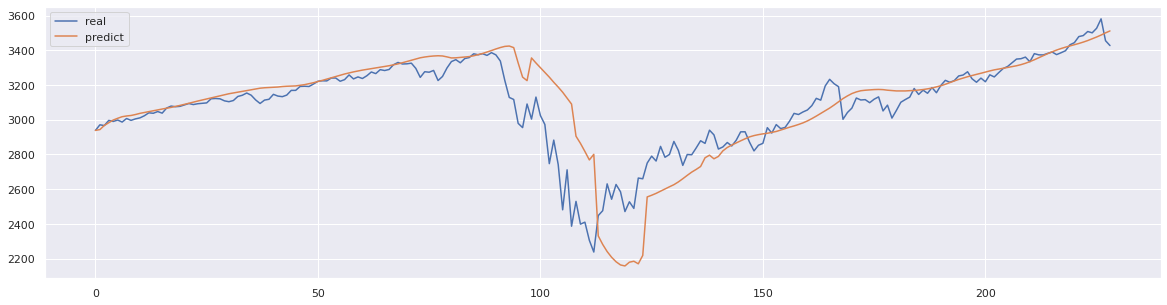

total buy 157
ratio buy/all test set: 0.6855895196506551
win num 101
lose num 56
revenue 188.17041015625


In [ ]:
y_train_pred=model.predict(X_train)
y_test_pred=model.predict(X_test)
print('train rmse:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('test rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)))
plt.figure(figsize=(20,5))
plt.plot(y_test,label='real')
plt.plot(y_test_pred,label='predict')
plt.legend()
plt.show()
profit(pd.Series(y_test.flatten()),pd.Series(y_test_pred.flatten()))

# FINAL model

In [ ]:
def get_indicators(data):
    # Get MACD
    data["macd"], data["macd_signal"], data["macd_hist"] = talib.MACD(data['close'])
    
    # Get MA10 and MA30
    data["ma10"] = talib.MA(data["close"], timeperiod=10)
    data["ma30"] = talib.MA(data["close"], timeperiod=30)
    
    # Get RSI
    data["rsi"] = talib.RSI(data["close"])
    return data

In [ ]:
from sklearn.linear_model import LinearRegression

class LinearRegressionModel(object):
    def __init__(self):
        self.df_result = pd.DataFrame(columns=['Actual', 'Predicted'])

    def get_model(self):
        return LinearRegression(fit_intercept=False)

    def learn(self, df, ys, start_date, end_date, lookback_period=20):
        model = self.get_model()
        #print('++def learn')
        #print('start_date',start_date)
        #print('end_date',start_date)
        #print('lookback_period',lookback_period)
        for date in df[start_date:end_date].index:
            # Fit the model
            x = self.get_prices_since(df, date, lookback_period)
            y = self.get_prices_since(ys, date, lookback_period)
            #print('----date',date)
            #print('x',x)
            #print('y',y)
            #print('y.ravel()',y.ravel())
            #print('x.shape',x.shape)
            #print('y.ravel().shape',y.ravel().shape)
            model.fit(x, y.ravel())
            #print('model.predict(x)',model.predict(x))
            # Predict the current period
            #print('Predict the current period')
            #print('date ',date)
            x_current = df.loc[date].values
            [y_pred] = model.predict([x_current])
            #print('x_current',x_current)
            #print('[y_pred]',[y_pred])

            # Store predictions
            new_index = pd.to_datetime(date, format='%Y-%m-%d')
            y_actual = ys.loc[date]
            #print('y_actual',y_actual)
            self.df_result.loc[new_index] = [y_actual, y_pred]

    def get_prices_since(self, df, date_since, lookback):

        index = df.index.get_loc(date_since) # current date
        #print('++def get_prices_since')
        #print('date_since',date_since)
        #print('index',index)
        #print('index-lookback:index',index-lookback,index) 
        return df.iloc[index-lookback:index] #current date - 20 : current date


In [ ]:
def profit(true,predict):
  buy=0
  win=0
  lose=0
  revenue=[]
  for i in range(len(predict)-1):
    if predict.values[i+1] > true.values[i]:
      buy+=1
      result=true.values[i+1]-true.values[i]
      revenue.append(result)
      if result >0:
        win+=1
      else:
        lose+=1
  print('total buy',buy)      
  print('ratio buy/all test set:',buy/len(predict))      
  print('win num',win)
  print('lose num',lose)
  print('revenue',sum(revenue))

In [ ]:
from yahoo_fin.stock_info import get_data

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
#ML normal ML
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import TheilSenRegressor, HuberRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
#ML ensembles
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
#Special
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [ ]:
stock_code={'Apple':'AAPL', 'Microsoft':'MSFT','Facebook':'Fb','Amazon':'AMZN',
            'Twitter':'TWTR','SP500':'^GSPC'}


In [ ]:
def stock_result(code):
  df= get_data(stock_code[code],  start_date = '2016-01-01',
                            end_date='2020-09-05',
                        index_as_date = True, interval="1d")
  nflx_df2 = get_indicators(df)
  df_indicator=nflx_df2
  df_indicator=df_indicator.drop(['ticker'],axis=1)
  df_indicator.dropna(inplace=True)
  print('df_indicator shape:',df_indicator.shape)
  x=df_indicator.iloc[:,6:]
  y=df_indicator['adjclose']
  print(x.shape)
  print(y.shape)
  model = LinearRegressionModel()
  model.learn(x, y, start_date='2017', 
                        end_date='2020', lookback_period=10)
  model.df_result.plot(
      title='JPM prediction by OLS', 
      style=['-', '--'], figsize=(12,5));
  y_test=model.df_result.Actual[-186:]
  y_test_pred=model.df_result.Predicted[-186:]
  print('test rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)))
  profit(y_test,y_test_pred)

df_indicator shape: (1145, 12)
(1145, 6)
(1145,)
test rmse: 24.42831055848921
total buy 115
ratio buy/all test set: 0.6182795698924731
win num 108
lose num 7
revenue 4010.890625


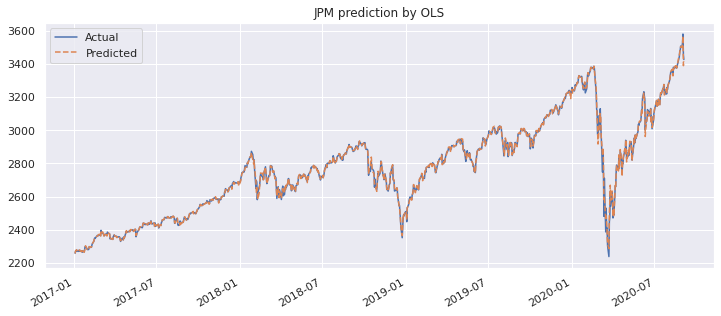

In [ ]:
stock_result('SP500')

df_indicator shape: (1145, 12)
(1145, 6)
(1145,)
test rmse: 1.6070032836918617
total buy 106
ratio buy/all test set: 0.5698924731182796
win num 98
lose num 8
revenue 337.90528869628906


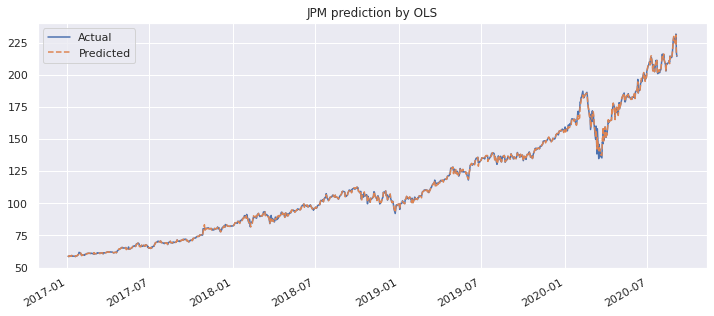

In [ ]:
stock_result('Microsoft')

df_indicator shape: (1145, 12)
(1145, 6)
(1145,)
test rmse: 2.2141107844253796
total buy 115
ratio buy/all test set: 0.6182795698924731
win num 105
lose num 10
revenue 422.4500274658203


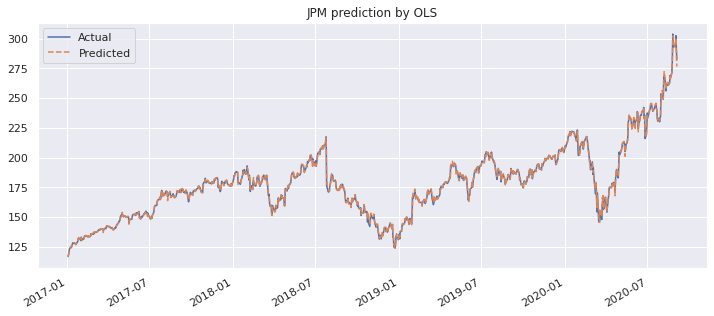

In [ ]:
stock_result('Facebook')

df_indicator shape: (1145, 12)
(1145, 6)
(1145,)
test rmse: 19.039606315402885
total buy 115
ratio buy/all test set: 0.6182795698924731
win num 108
lose num 7
revenue 4629.47998046875


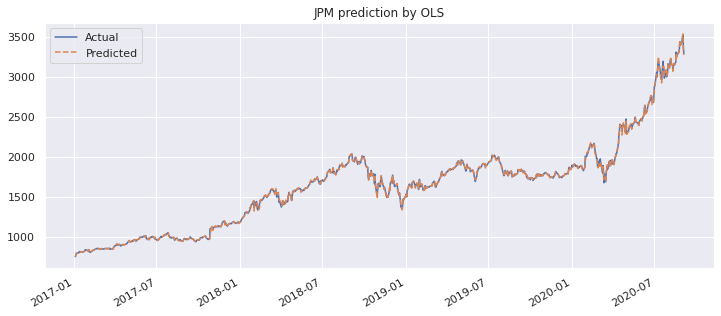

In [ ]:
stock_result('Amazon')

df_indicator shape: (1145, 12)
(1145, 6)
(1145,)
test rmse: 0.3822805672709287
total buy 102
ratio buy/all test set: 0.5483870967741935
win num 98
lose num 4
revenue 81.26000785827637


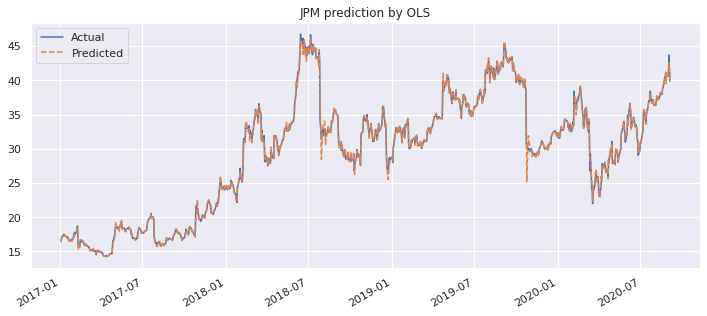

In [ ]:
stock_result('Twitter')